# Implementacia Gradient Boosting

In [41]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score



from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, fbeta_score, f1_score
from imblearn.metrics import specificity_score


from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score




pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

In [20]:
RATIOS = ['L1',
       'L2', 'L3', 'NCL_CF', 'CASH_TA', 'INV_COGS', 'CC_SAL', 'TL_COST',
       'CL_COST', 'SAL_TA', 'EQ_TA', 'EQ_TL', 'CL_CC', 'LTC_NCA', 'TZ',
       'CF_TL', 'CL_TA', 'NCL_TA', 'EBT_REV', 'ROS', 'EAT_REV', 'ROA', 'ROE',
       'CF_TA', 'CF_SAL', 'LABOR_EAT', 'LABOR_REV']

PRIMARY_VALUES = [
    'CA', 'CASH',
       'CL', 'EQ', 'NCL', 'TA', 'TL', 'CC', 'INV', 'CF_NETTO', 'CF_SELFFIN',
       'REV', 'VA', 'OE', 'EAT', 'EBIT', 'SAL', 'COST', 'INT'
]


REDUCED_FEATURE_SET = ['L1', 'L3', 'EQ_TA', 'CL_CC', 'LTC_NCA', 'TZ', 'CF_TL', 'CL_TA', 'ROS', 'ROA', 'ROE']

SKNACE_ONE_HOT = ['sknace_C', 'sknace_F', 'sknace_G', 'sknace_H', 'sknace_M', 'sknace_other']

FINAL_FEATURE_SET = ['L3', 'EQ_TA', 'LTC_NCA', 'TZ', 'CF_TL', 'CL_TA', 'ROS', 'ROA', 'ROE']


## Priprava dat

In [21]:
training_raw = pd.read_csv('../../../DATA/FINAL/final/training_sample.csv')
testing_raw = pd.read_csv('../../../DATA/FINAL/final/testing_sample.csv')
training_raw.shape, testing_raw.shape

((7188, 107), (1797, 107))

In [22]:
SAL_CLASSES = training_raw['sal_class'].unique()
SKNACE_GROUPS = training_raw['sknace_division_normalized'].unique()

In [23]:
training_filled = training_raw.copy()
testing_filled = testing_raw.copy()

In [27]:


def eval(real, pred, label):
    print(f'real_positives = {sum(real)}, total = {len(real)}')
    recall = recall_score(real, pred)
    accuracy = accuracy_score(real, pred)
    print(f"{label} Accuracy:", accuracy)
    print(f"{label} Precision:", precision_score(real, pred))
    print(f"{label} Recall:", recall)
    print(f"{label} Specificity:", specificity_score(real, pred))
    print(f"{label} F1 Score:", f1_score(real, pred))

    cm = confusion_matrix(real, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(label)
    plt.show()

In [28]:

Q = training_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

control_group_ratio = 1.5

training_balanced = (
    pd.concat(
        [
            training_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q * control_group_ratio)),
            training_filled.query('combined_issue_criteria_3y_off == 1').sample(Q),
        ], axis = 0
    )
)



Q_test = testing_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

testing_balanced = (
    pd.concat(
        [
            testing_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q_test * control_group_ratio)),
            testing_filled.query('combined_issue_criteria_3y_off == 1').sample(Q_test),
        ], axis = 0
    )
)


X_train_balanced = training_balanced[FINAL_FEATURE_SET].values
y_train_balanced = training_balanced['combined_issue_criteria_3y_off'].values

X_test_balanced = testing_balanced[FINAL_FEATURE_SET].values
y_test_balanced = testing_balanced['combined_issue_criteria_3y_off'].values

X_train_imbalanced = training_filled[FINAL_FEATURE_SET].values
y_train_imbalanced = training_filled['combined_issue_criteria_3y_off'].values

X_test_imbalanced = testing_filled[FINAL_FEATURE_SET].values
y_test_imbalanced = testing_filled['combined_issue_criteria_3y_off'].values



# X_train_valid_balanced, X_valid_valid_balanced, y_train_valid_balanced, y_valid_valid_balanced = train_test_split(
#     X_train_balanced, y_train_balanced, test_size=0.2, random_state=42)


X_train_valid_imbalanced, X_valid_valid_imbalanced, y_train_valid_imbalanced, y_valid_valid_imbalanced = train_test_split(
    X_train_imbalanced, y_train_imbalanced, test_size=0.2, random_state=42)


from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

# Assuming X_train_valid_imbalanced and y_train_valid_imbalanced are already defined
# Count the number of samples in each class
counter = Counter(y_train_valid_imbalanced)
print(f"Original class distribution: {counter}")

# Calculate the number of samples needed for the majority class (class 0) to achieve a 3:2 ratio
minority_class_count = counter[1]
desired_majority_class_count = (minority_class_count * 3) // 2

# Define the sampling strategy for RandomUnderSampler
sampling_strategy = {0: desired_majority_class_count, 1: minority_class_count}

# Apply RandomUnderSampler with the defined sampling strategy
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_valid_balanced, y_train_valid_balanced = rus.fit_resample(X_train_valid_imbalanced, y_train_valid_imbalanced)



Original class distribution: Counter({0.0: 5183, 1.0: 567})


In [31]:
# print('\nTEST')
# print(pd.Series(y_test_balanced).value_counts())
# print(pd.Series(y_test_imbalanced).value_counts())

# print('\nTRAIN')
# print(pd.Series(y_train_balanced).value_counts())
# print(pd.Series(y_train_imbalanced).value_counts())

# print('\nTRAIN W VALID')
# print(pd.Series(y_train_valid_balanced).value_counts())
# print(pd.Series(y_train_valid_imbalanced).value_counts())

# print('\nVALID')
# print(pd.Series(y_valid_valid_imbalanced).value_counts())

## Hyper param optimization

In [34]:

# # # first generation
# param_grid = {
#     'n_estimators': [10, 20, 30, 40, 50],        # Number of boosting stages
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],    # Learning rate shrinks the contribution of each tree
#     'max_depth': [2, 3, 4, 5],                  # Maximum depth of the individual estimators
#     'min_samples_split': [2, 5, 10],            # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2, 4],              # Minimum number of samples required to be at a leaf node
#     'subsample': [0.6, 0.8, 1.0],               # Fraction of samples used for fitting the individual base learners
# }

# second generation
param_grid = {
    'learning_rate': [0.03, 0.05, 0.07, 0.1],
    'max_depth': [3, 4],
    'min_samples_split': [10, 2, 5],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [30, 40, 50],
    'subsample': [0.8]
}


gb_classifier = GradientBoostingClassifier(
    random_state=37)


grid_search = GridSearchCV(estimator=gb_classifier, param_grid=param_grid, cv=5, n_jobs=4, verbose=10, scoring='f1')
grid_search.fit(X_train_balanced, y_train_balanced)

grid_search.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


{'learning_rate': 0.1,
 'max_depth': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 30,
 'subsample': 0.8}

In [36]:
# Extract grid search results
cv_results = pd.DataFrame(grid_search.cv_results_)

# Display grid search results
# print(cv_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']])

# Sort by rank to see the best combinations first
sorted_cv_results = cv_results.sort_values(by='rank_test_score')
sorted_cv_results.query('mean_test_score > 0.67 and std_test_score <= 0.022').head(10)





,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.162187,0.011529,0.002001,0.001098,0.1,4,2,10,30,0.8,"{'learning_rate': 0.1, 'max_depth': 4, 'min_sa...",0.689394,0.679688,0.674157,0.658824,0.653992,0.671211,0.013123,1


In [37]:
head = cv_results.query('mean_test_score > 0.67 and std_test_score <= 0.022').head(8)

new_params = dict()

for param_name in cv_results.columns:
    if 'param_' in param_name:
        new_params[param_name] = list(head[param_name].unique())

display(new_params)      


{'param_learning_rate': [0.1],
 'param_max_depth': [4],
 'param_min_samples_leaf': [2],
 'param_min_samples_split': [10],
 'param_n_estimators': [30],
 'param_subsample': [0.8]}

## VALIDATION

In [38]:
pd.Series(y_valid_valid_imbalanced).value_counts()

0.0    1305
1.0     133
dtype: int64

In [39]:
def predict_w_threshold(estimator, X, threshold):
    proba = estimator.predict_proba(X)[:, 1]
    return (proba >= threshold).astype(int)

real_positives = 133.0, total = 1438
SEMIFINAL MODEL IMBALANCED Accuracy: 0.827538247566064
SEMIFINAL MODEL IMBALANCED Precision: 0.2939068100358423
SEMIFINAL MODEL IMBALANCED Recall: 0.6165413533834586
SEMIFINAL MODEL IMBALANCED Specificity: 0.8490421455938697
SEMIFINAL MODEL IMBALANCED F1 Score: 0.39805825242718446


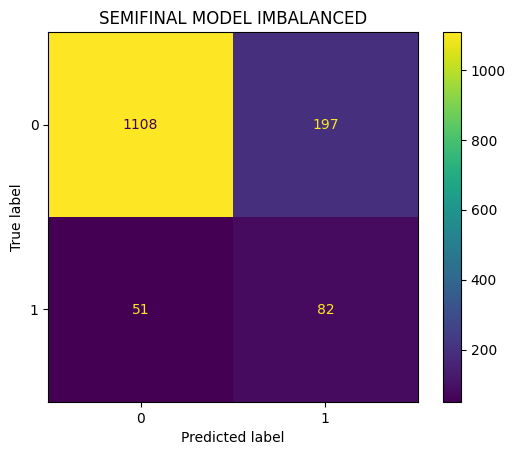

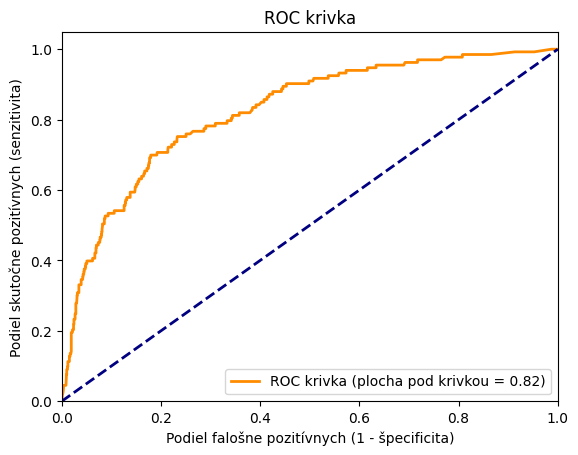

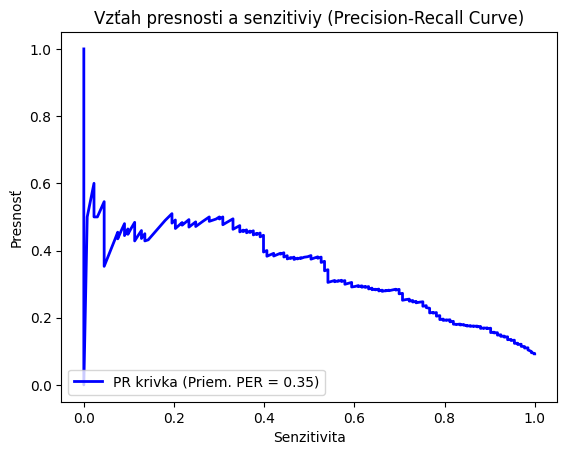

real_positives = 133.0, total = 1438
FINAL MODEL IMBALANCED Accuracy: 0.7635605006954103
FINAL MODEL IMBALANCED Precision: 0.2457002457002457
FINAL MODEL IMBALANCED Recall: 0.7518796992481203
FINAL MODEL IMBALANCED Specificity: 0.7647509578544062
FINAL MODEL IMBALANCED F1 Score: 0.37037037037037035


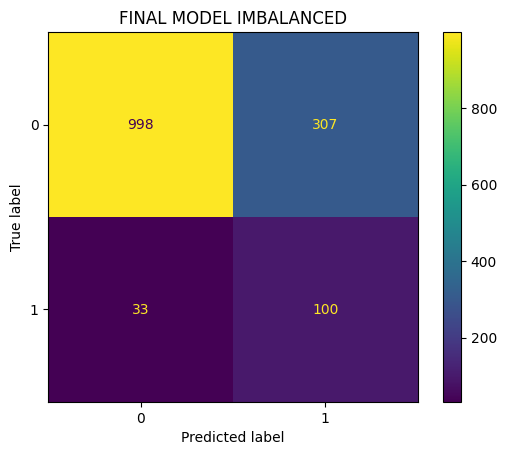

In [42]:

gb_classifier = GradientBoostingClassifier(
    random_state = 37,
    max_depth= 3,
    min_samples_leaf = 2,
    min_samples_split = 5,
    n_estimators = 30,
    subsample = 0.8
)

gb_classifier.fit(X_train_valid_balanced, y_train_valid_balanced)

eval(y_valid_valid_imbalanced, gb_classifier.predict(X_valid_valid_imbalanced), 'SEMIFINAL MODEL IMBALANCED')


y_probs = gb_classifier.predict_proba(X_valid_valid_imbalanced)[:, 1]

fpr, tpr, thresholds = roc_curve(y_valid_valid_imbalanced, y_probs)

roc_auc = roc_auc_score(y_valid_valid_imbalanced, y_probs)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivka (plocha pod krivkou = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Podiel falošne pozitívnych (1 - špecificita)')
plt.ylabel('Podiel skutočne pozitívnych (senzitivita)')
plt.title('ROC krivka')
plt.legend(loc='lower right')
plt.show()

precision, recall, thresholds = precision_recall_curve(y_valid_valid_imbalanced, y_probs)

average_precision = average_precision_score(y_valid_valid_imbalanced, y_probs)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR krivka (Priem. PER = {average_precision:.2f})')
plt.xlabel('Senzitivita')
plt.ylabel('Presnosť')
plt.title('Vzťah presnosti a senzitiviy (Precision-Recall Curve)')
plt.legend(loc='lower left')
plt.show()


eval(y_valid_valid_imbalanced, predict_w_threshold(gb_classifier, X_valid_valid_imbalanced, 0.4), 'FINAL MODEL IMBALANCED')

## FINAL TESTING

real_positives = 700.0, total = 1750
FINAL MODEL TRAIN BALANCED Accuracy: 0.7914285714285715
FINAL MODEL TRAIN BALANCED Precision: 0.7824620573355818
FINAL MODEL TRAIN BALANCED Recall: 0.6628571428571428
FINAL MODEL TRAIN BALANCED Specificity: 0.8771428571428571
FINAL MODEL TRAIN BALANCED F1 Score: 0.7177107501933488


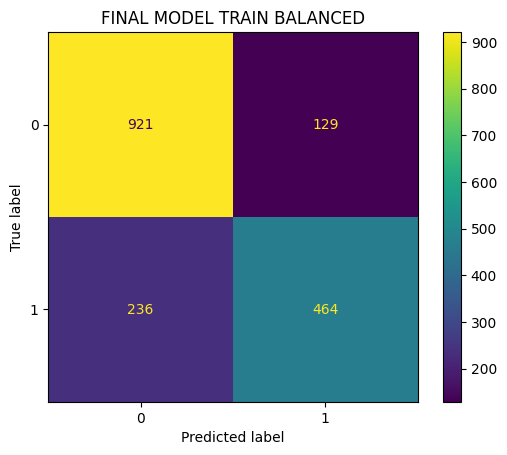

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.7302325581395349
FINAL MODEL BALANCED Precision: 0.6794871794871795
FINAL MODEL BALANCED Recall: 0.6162790697674418
FINAL MODEL BALANCED Specificity: 0.8062015503875969
FINAL MODEL BALANCED F1 Score: 0.6463414634146342


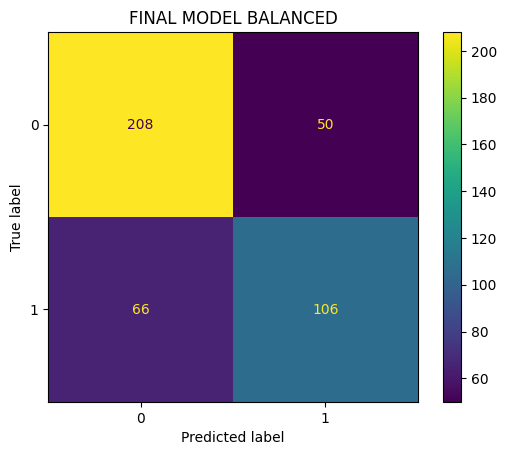

real_positives = 172.0, total = 1797
FINAL MODEL IMBALANCED Accuracy: 0.8107957707289928
FINAL MODEL IMBALANCED Precision: 0.2789473684210526
FINAL MODEL IMBALANCED Recall: 0.6162790697674418
FINAL MODEL IMBALANCED Specificity: 0.8313846153846154
FINAL MODEL IMBALANCED F1 Score: 0.38405797101449274


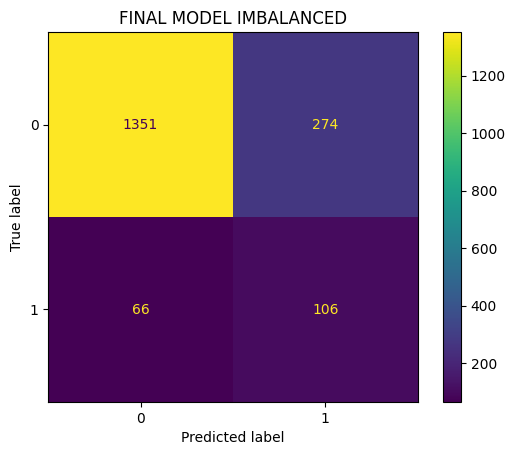

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.727906976744186
FINAL MODEL BALANCED Precision: 0.6470588235294118
FINAL MODEL BALANCED Recall: 0.7034883720930233
FINAL MODEL BALANCED Specificity: 0.7441860465116279
FINAL MODEL BALANCED F1 Score: 0.6740947075208914


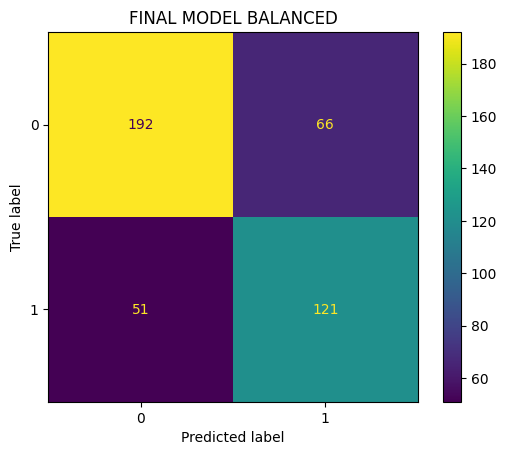

real_positives = 172.0, total = 1797
FINAL MODEL IMBALANCED Accuracy: 0.7557039510294936
FINAL MODEL IMBALANCED Precision: 0.23772102161100198
FINAL MODEL IMBALANCED Recall: 0.7034883720930233
FINAL MODEL IMBALANCED Specificity: 0.7612307692307693
FINAL MODEL IMBALANCED F1 Score: 0.35535976505139505


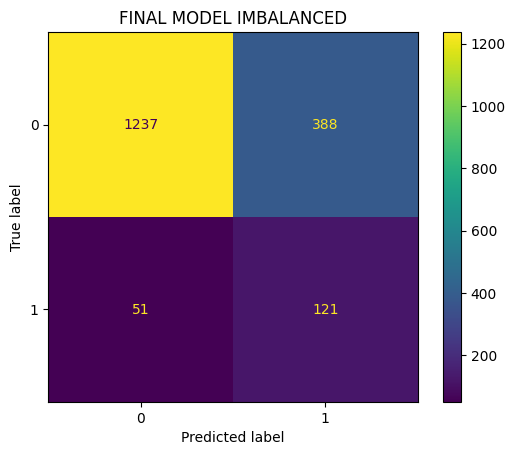

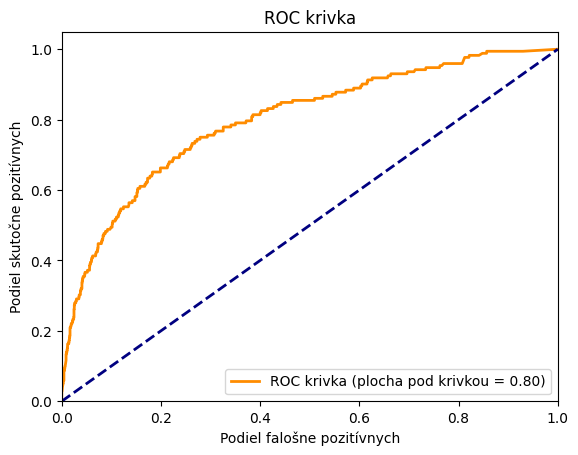

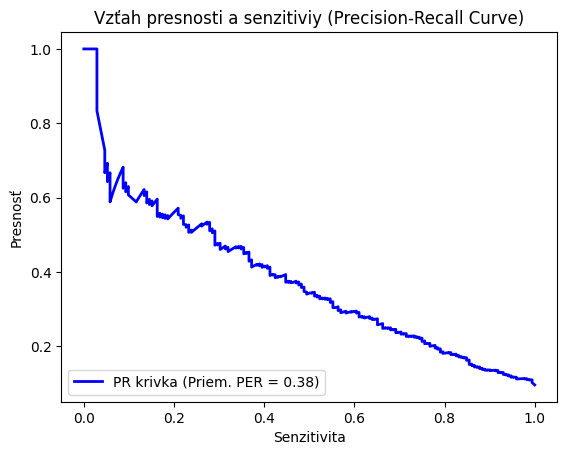

In [43]:
rf_final = GradientBoostingClassifier(
    random_state = 37,
    max_depth= 3,
    min_samples_leaf = 2,
    min_samples_split = 5,
    n_estimators = 30,
    subsample = 0.8
)


rf_final.fit(X_train_balanced, y_train_balanced)


eval(y_train_balanced, rf_final.predict(X_train_balanced), 'FINAL MODEL TRAIN BALANCED')
eval(y_test_balanced, rf_final.predict(X_test_balanced), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, rf_final.predict(X_test_imbalanced), 'FINAL MODEL IMBALANCED')


eval(y_test_balanced,predict_w_threshold(rf_final, X_test_balanced, 0.4), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, predict_w_threshold(rf_final, X_test_imbalanced, 0.4), 'FINAL MODEL IMBALANCED')

y_probs = rf_final.predict_proba(X_test_imbalanced)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_imbalanced, y_probs)

roc_auc = roc_auc_score(y_test_imbalanced, y_probs)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivka (plocha pod krivkou = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Podiel falošne pozitívnych')
plt.ylabel('Podiel skutočne pozitívnych')
plt.title('ROC krivka')
plt.legend(loc='lower right')
plt.show()

precision, recall, thresholds = precision_recall_curve(y_test_imbalanced, y_probs)

average_precision = average_precision_score(y_test_imbalanced, y_probs)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR krivka (Priem. PER = {average_precision:.2f})')
plt.xlabel('Senzitivita')
plt.ylabel('Presnosť')
plt.title('Vzťah presnosti a senzitiviy (Precision-Recall Curve)')
plt.legend(loc='lower left')
plt.show()

